# Planet Amazon Image Classification - Machine Learning - Model Comparison

In this notebook we import the deep learning models generated in notebooks 1-4 and compare their performances

## Importing the Data

In [4]:
#import modules
import numpy as np 
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
#import pickle
from IPython.display import display
from skimage import io
%matplotlib inline

# Define files and directories
#os.chdir('C:/Users/isado/Documents/SpringBoard/Capstone2/')
         
# Create DataFrame with training labels
train_labels = pd.read_csv('../train_classes.csv')
#train_labels = pd.read_csv('/floyd/input/amazon_train_classes/train_classes.csv')

In [5]:
#Extracting unique labels
labels = []
for tags in train_labels.tags.values:
    label = tags.split(' ')
    for subitem in label:
        if subitem not in labels:
            labels.append(subitem)

#One Hot encoding labels
for label in labels:
    train_labels[label] = train_labels['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    
train_labels.index = train_labels.image_name

## Model Comparison

### Baseline Random Forest Model Performance

In [9]:
#Load average RGB values calculated in the EDA notebook
mean_rgb_images_df = pd.read_csv('..\mean_RGB_images.csv', index_col=0)
mean_rgb_images_df.index.name = 'image_name'

#Adding back labels to average RGB data for each image
mean_rgb_images_df = mean_rgb_images_df.merge(train_labels.drop('image_name',axis=1), left_index=True, right_on='image_name')
mean_rgb_images_df.drop('tags', axis=1, inplace=True)

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score
import time

#subset data for testing the code and finding best params
mean_rgb_images_subset = mean_rgb_images_df.iloc[:27000,:]

#Splitting target and features
X = mean_rgb_images_subset[['R','G','B']]
y = mean_rgb_images_subset.drop(['R','G','B'],axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

###########################################################################
# #Instantiate the model
# rfm = RandomForestClassifier()

# #Tuning parameters and performing cross-validation
# # Setup the hyperparameter grid
# n_estimators = np.arange(100, 400, 100)#number of trees in Forest
# max_depth = np.arange(1,12)#depth of trees
# param_grid = {'n_estimators': n_estimators, 'max_depth':max_depth}

# # Instantiate the GridSearchCV object: rf_cv
# rf_cv = GridSearchCV(rfm, param_grid, cv=5, scoring='f1_samples')

# #Fitting the model
# rf_cv.fit(X_train, y_train)

# print("Tuned Random Forest Parameters: {}".format(rf_cv.best_params_)) 
# print("Best score is {}".format(rf_cv.best_score_))

# Tuned Random Forest Parameters: {'max_depth': 10, 'n_estimators': 200}
# Best score is 0.7207079883079882

#####################################################################

start_time = time.time()
#Instantiate model with best parameters from GridSearchCV
rfm = RandomForestClassifier(max_depth=10, n_estimators=200)

#Fitting the model
rfm.fit(X_train, y_train)

y_pred = rfm.predict(X_test)

end_time = time.time()

# Scoring with F beta
print('F beta score:', fbeta_score(np.asarray(y_test), y_pred, beta=2, average='samples'))
print(str((end_time-start_time))+' secs')

F beta score: 0.7050780067269349
18.92734408378601 secs


C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [8]:
from sklearn.metrics import recall_score, precision_score, f1_score

resulting_metrics = pd.DataFrame(recall_score(y_test, y_pred, average=None))
resulting_metrics.index = labels
resulting_metrics.columns = ['Recall']
resulting_metrics["Precision"] = precision_score(y_test, y_pred, average=None)
resulting_metrics['F1'] = f1_score(y_test, y_pred, average=None)
resulting_metrics

C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Recall,Precision,F1
haze,0.039813,0.515152,0.073913
primary,0.989165,0.955665,0.972127
agriculture,0.495345,0.657347,0.564962
clear,0.938593,0.831765,0.881956
water,0.026211,0.673469,0.050459
habitation,0.012618,0.727273,0.024806
road,0.275093,0.611570,0.379487
cultivation,0.000000,0.000000,0.000000
slash_burn,0.000000,0.000000,0.000000
cloudy,0.520958,0.746781,0.613757


### Deep Learning  - Performance Comparison Between Models

In [10]:
from skimage.transform import resize
from skimage.color import rgb2gray

#Function to load a specific image

def load_image(file_name, fig_type='jpg', size=256, n_channels=3):
    
    """Loads the requested image resized and converted to gray if n_channels == 1 specified"""
    
    img_path = ('../train-{}/{}.{}').format(fig_type,file_name,fig_type)
    #img_path = ('/floyd/input/amazon_images/{}.{}').format(file_name,fig_type)
    img = io.imread(img_path)
    img = resize(img, (size,size,3), mode='constant')
    if n_channels == 1:
        img = rgb2gray(img)[:, :, np.newaxis]
    
    return img

In [10]:
#Lookup dictionary containing the labels for each image sample, we will use this on our data generator object

labels_dict={}
labels_array = np.array(train_labels.iloc[:,-17:])

for i, sample in enumerate(train_labels.index):
    labels_dict[sample] = labels_array[i]

cloud_labels_dict={}
cloud_labels_array = np.array(cloud_labels.iloc[:,-17:])

for i, sample in enumerate(cloud_labels.index):
    cloud_labels_dict[sample] = cloud_labels_array[i]

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# import keras library
import keras

#RAM size limitation makes it so we have to process our data in mini-batches using a data generator

from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math

#adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(keras.utils.Sequence):
    
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=64, dim=(64,64), n_channels=3,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = list(np.empty((self.batch_size)))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = load_image(ID, size=self.dim[0], n_channels=self.n_channels)

            # Store class
            y[i] = self.labels[ID]

        return X, np.array(y)

C:\Users\isado\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
#Function to get f1-score metric for Keras
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [10]:
# Define test set data generator
params = {'dim': (64,64),
          'batch_size': 256,
          'n_classes': 17,
          'n_channels': 3,
          'shuffle': False}

test_set = train_labels.index[35000:40376]#test size needs to be an exact multiple of the batch size specified by the data generator

test_generator = DataGenerator(test_set, labels_dict, **params)

#Get True Labels
true_labels = train_labels.loc[test_set].iloc[:,-17:].values

#Read results file into dataframe
model_results = pd.read_csv(r'\Model_Results.csv', index_col=0)

In [11]:
#Models to compare, grayscale model will be loaded separately
models = ['baseline_model_20000n.h5',
          'batch_norm_model_20000n.tf',
          'mini_baseline_model_2000n.h5',
          'mini_upsampled_model_2000n.tf']

In [12]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve

def get_best_threshold(preds, true_labels):
    
    """Computes best threshold and best F1 score per class given predictions and true labels"""

    best_threshold_dict = {} #this dictionary will hold f1 scores per threshold for each label
    
    for col in range(preds.shape[1]):

        #get unique values for predictions generated by the model for this class rounded to the second decimal
        threshold_values = np.sort(np.unique(np.around((preds[:,col]),decimals=2)))

        #get true labels for this class
        true_labels_class = true_labels[:,col]

        best_f1 = 0

        for threshold in threshold_values:

            #Initialize class predictions with all zeros for each threshold
            preds_threshold = np.zeros(true_labels_class.shape)

            #generate predictions for given threshold
            threshold_indices = preds[:,col] > threshold
            preds_threshold[threshold_indices] = 1
            current_f1 = f1_score(true_labels_class, preds_threshold)

            if current_f1 > best_f1:
                best_f1 = current_f1
                best_threshold = threshold

        best_threshold_dict[labels[col]] = {'Best_Threshold': best_threshold, 'Best_F1': best_f1}

    return (pd.DataFrame.from_dict(best_threshold_dict).T)

In [13]:
from keras.models import load_model

for model_name in models:
    #load the model
    print(model_name)
    model = load_model(model_name, custom_objects={'f1_m': f1_m, 'precision_m':precision_m, 'recall_m':recall_m})
    #get test set predictions
    preds = model.predict_generator(test_generator,steps=len(test_set)//params['batch_size'],verbose=1)
    model_results[['Threshold_{}'.format(model_name.split('_2')[0]),'Best_F1_{}'.format(model_name.split('_2')[0])]] = get_best_threshold(preds, true_labels)

baseline_model_20000n.h5
21/21 [==============================] - 60s 3s/step
batch_norm_model_20000n.tf
21/21 [==============================] - 52s 2s/step
mini_baseline_model_2000n.h5
21/21 [==============================] - 61s 3s/step
mini_upsampled_model_2000n.tf
21/21 [==============================] - 61s 3s/step


In [24]:
#processing grayscale separately due to variable input image size

# Define test set data generator for grayscale model
params_gray = {'dim': (128,128),
          'batch_size': 256,
          'n_classes': 17,
          'n_channels': 1,
          'shuffle': False}

test_generator_gray = DataGenerator(test_set, labels_dict, **params_gray)

model = load_model('grayscale_model_20000n.tf', custom_objects={'f1_m': f1_m, 'precision_m':precision_m, 'recall_m':recall_m})

preds_grayscale = model.predict_generator(test_generator_gray,steps=len(test_set)//params['batch_size'],verbose=1)

model_results[['Threshold_grayscale','Best_F1_grayscale']] = get_best_threshold(preds_grayscale, true_labels) 
model_results.loc['Average_F1'] = model_results.mean()
model_results

,Best_Threshold_Transfer,Best_F1_Transfer,Threshold_baseline_model,Best_F1_baseline_model,Threshold_batch_norm_model,Best_F1_batch_norm_model,Threshold_mini_baseline_model,Best_F1_mini_baseline_model,Threshold_mini_upsampled_model,Best_F1_mini_upsampled_model,Threshold_grayscale,Best_F1_grayscale
haze,0.180000,0.718881,0.350000,0.664987,0.230000,0.632319,0.120000,0.372581,0.20,0.523187,0.150000,0.576714
primary,0.380000,0.982964,0.550000,0.976790,0.730000,0.975798,0.770000,0.970594,0.44,0.970225,0.760000,0.976808
agriculture,0.230000,0.824270,0.450000,0.761665,0.380000,0.739468,0.240000,0.552152,0.24,0.641887,0.390000,0.708231
clear,0.690000,0.963963,0.540000,0.945970,0.530000,0.940741,0.510000,0.869304,0.49,0.889878,0.490000,0.913998
water,0.280000,0.726793,0.270000,0.465152,0.240000,0.440257,0.150000,0.335255,0.18,0.376157,0.240000,0.417959
habitation,0.240000,0.548691,0.250000,0.479151,0.290000,0.460641,0.120000,0.232019,0.11,0.345824,0.200000,0.467236
road,0.280000,0.727104,0.400000,0.627288,0.340000,0.612658,0.280000,0.429630,0.23,0.541016,0.350000,0.620148
cultivation,0.350000,0.556810,0.220000,0.446857,0.190000,0.418142,0.080000,0.225499,0.11,0.287125,0.170000,0.368526
slash_burn,0.050000,0.113821,0.030000,0.040541,0.010000,0.026846,0.010000,0.014925,0.01,0.020938,0.000000,0.013671
cloudy,0.500000,0.811650,0.270000,0.716535,0.100000,0.698795,0.170000,0.615942,0.34,0.596154,0.130000,0.682060


In [135]:
f1_summary = (model_results[model_results.filter(like='F1').columns]).copy()
f1_summary.columns = ['Transfer Model (VGG16)', 'Baseline CNN','Baseline CNN w/ Batch Norm', 'Baseline CNN Small Training Set', 'Baseline CNN Small Training Set Upsampled','Grayscale CNN']

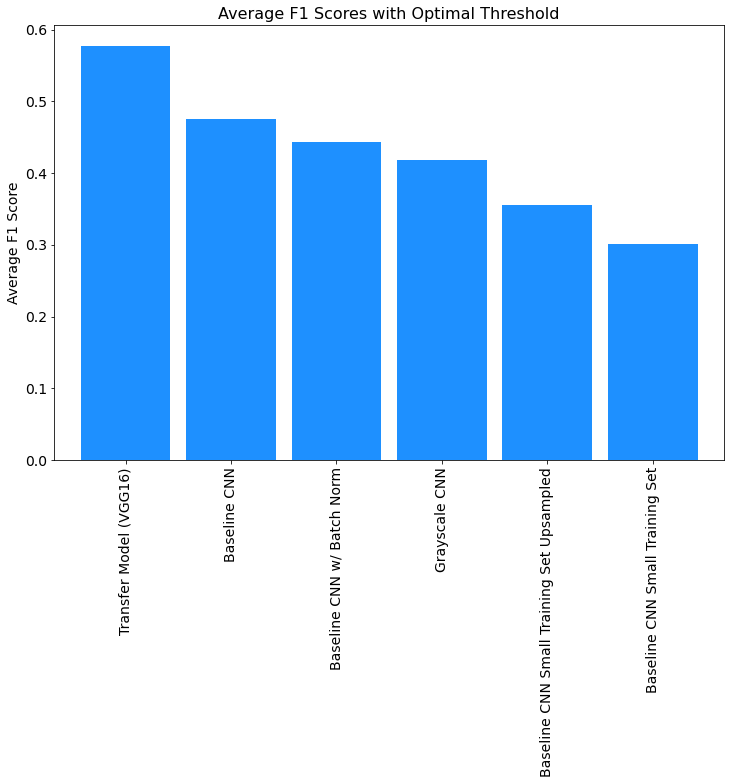

In [136]:
f1_summary.loc['Average_F1'].sort_values(ascending = False).plot(kind='bar', width=.85, figsize = (12,8), color = 'dodgerblue', fontsize = 14)
plt.title('Average F1 Scores with Optimal Threshold', fontsize = 16)
plt.ylabel('Average F1 Score', fontsize = 14);

 In the figure above it becomes clear that the VGG16 model has the highest average F1 score with the Baseline CNN performing second best. From the plot we can also observe the effects of reducing the size of our training set, as the worst performing model difers from the Baseline CNN only in its training set size (2000 vs 20000 images). Batch normalization slightly reduced the baseline model's performance, and the higher resolution provided by the grayscale model also yielded worst results. 
 
Below we explore how much the transfer model improved results for the high count and low count labels over our Baseline CNN:

In [137]:
f1_summary['label_counts'] = train_labels.drop(['image_name', 'tags'], axis = 1).sum()
f1_summary.sort_values(by='label_counts', ascending = False, inplace = True)

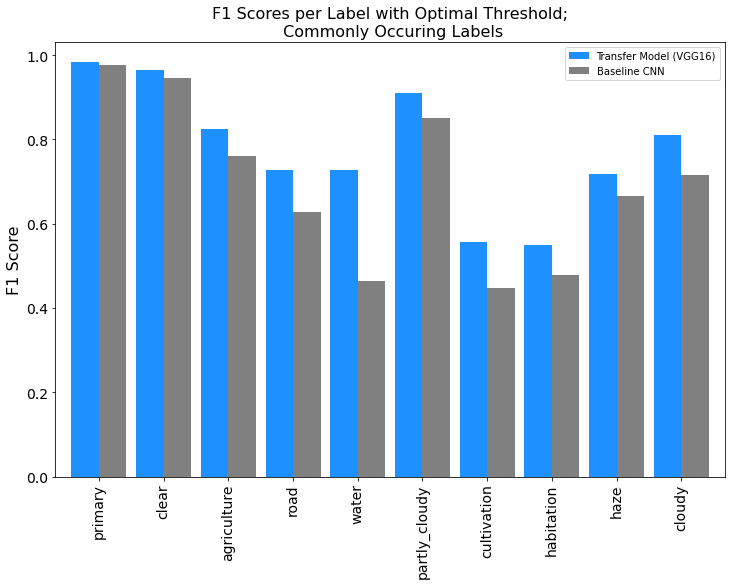

In [138]:
f1_summary[f1_summary['label_counts'] > 2000].loc[:,['Transfer Model (VGG16)', 'Baseline CNN']].plot(kind='bar', width=.85, figsize = (12,8), color = ['dodgerblue', 'gray'], fontsize = 14)
plt.title('F1 Scores per Label with Optimal Threshold;\n Commonly Occuring Labels', fontsize = 16)
plt.ylabel('F1 Score', fontsize = 16);

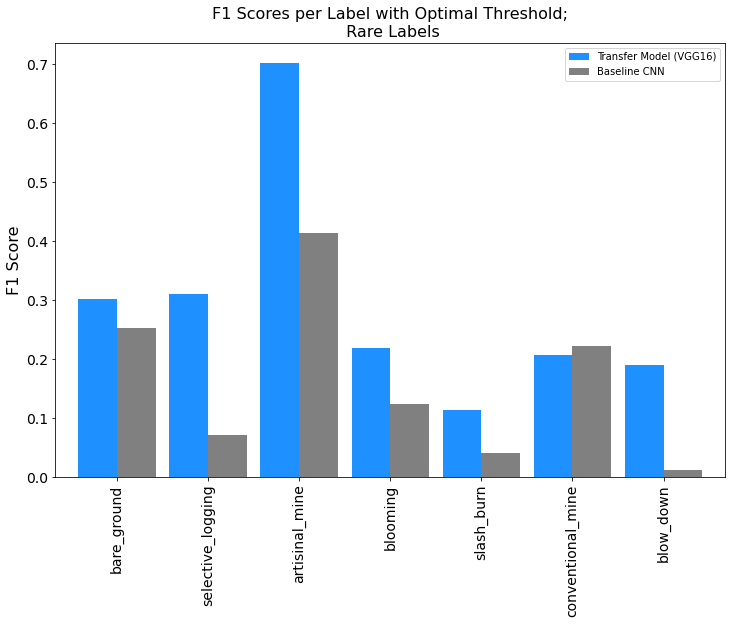

In [139]:
f1_summary[f1_summary['label_counts'] <= 2000].loc[:,['Transfer Model (VGG16)', 'Baseline CNN']].plot(kind='bar', width=.85, figsize = (12,8), color = ['dodgerblue', 'gray'], fontsize = 14)
plt.title('F1 Scores per Label with Optimal Threshold;\n Rare Labels', fontsize = 16)
plt.ylabel('F1 Score', fontsize = 16);